In [5]:
# Just testing my Spatial AE

import torch
import matplotlib.pyplot as plt
import numpy as np

from torchvision import transforms

from torch.utils.data import TensorDataset, DataLoader

from tqdm.autonotebook import tqdm, trange

from utils.models import *
from utils.model_tools import *


In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")


Using cuda device


In [7]:
torch.manual_seed(321)

model_file = 'model_files/default_env_spatial_ae.pt'

# need to consider if you actually want to transform
transform = transforms.Compose([
        transforms.ToTensor()])

trainset_file = 'data/default_trainset_15000.pt'
testset_file = 'data/default_testset_2713.pt'

#if load_dataset: # notebook kernel likes to die when we build it so load it when possible
#    train_data = TensorDataset(torch.load(trainset_file))
#    test_data = TensorDataset(torch.load(testset_file))
#else:
frames_files = ['data/frames_default_2023-10-26-00-20-15.npy', 
                'data/frames_default_2023-10-26-01-07-09.npy',
                'data/frames_default_2023-10-26-16-58-26.npy']
    
raw_frames = np.load(frames_files[0])
print(raw_frames.shape)
for i in range(1, len(frames_files)):
    print(np.load(frames_files[i]).shape)
    f = np.load(frames_files[i])
    raw_frames = np.concatenate((raw_frames, f), axis=0)

train_data = SequentialFrameDataset(raw_frames[:15000])#, transform=transform)
test_data = SequentialFrameDataset(raw_frames[15001:])#, transform=transform)

batch_size = 32
# does it matter in this instance if you shuffle? I think you can get away with it
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=2)

(5500, 128, 128, 3)
(10000, 128, 128, 3)
(2213, 128, 128, 3)
(15000, 3, 128, 128)
(2712, 3, 128, 128)


torch.Size([7, 3, 128, 128])
(3, 132, 912)


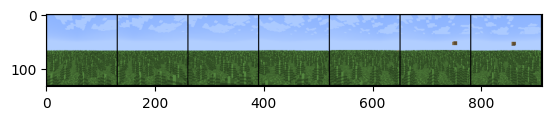

(3, 128, 128)


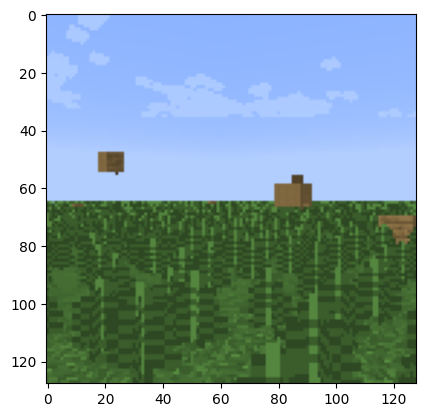

In [12]:
# Take a look at the sequence of images
import torchvision

def imshow(img):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    print(npimg.shape)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

seq, preds = next(iter(train_loader))
print(seq[0].shape)
imshow(torchvision.utils.make_grid(seq[0]))
imshow(preds[0])

#imshow(raw_frames[0])

In [11]:
model = SpatialAE()
model.to(device)
print(len(train_loader))

num_epochs = 30 # in the actual example this will be 200
steps_per_epoch = len(train_loader) #?

learning_rate = 0.1
weight_decay = 5 * 10**-6

loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=weight_decay, nesterov=True)
lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, learning_rate, epochs=num_epochs, steps_per_epoch=steps_per_epoch)


59


In [ ]:
train_losses_file = 'logs/spatial-ae-default-ep30-train.txt'
test_losses_file = 'logs/spatial-ae-cifar10-ep30-test.txt'

train_losses = []
test_losses = []
t = trange(num_epochs)

for epoch in t:
    print(f"Epoch {epoch+1}\n-------------------------------")
    train_loss = train(train_loader, model, loss_fn, optimizer, device)
    test_loss = test(test_loader, model, loss_fn, device)
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    
    #t.set_description(f"Epoch {epoch} train loss: {epoch_loss_train[-1]:.3f}")
    lr_scheduler.step()
    
torch.save(model.state_dict(), model_file)

with open(train_losses_file, 'w') as fp:
    for s in train_losses:
        fp.write("%s\n" % s)
        
with open(test_losses_file, 'w') as fp:
    for x in test_losses:
        fp.write("%s\n" % x)

print("Done!")
